In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator to rescale images and apply augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

dataset_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # We need shuffle=False to predict in order
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
from tensorflow.keras import layers, models

# Simple CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10, validation_data=val_generator)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 975ms/step - accuracy: 0.8103 - loss: 0.5438 - val_accuracy: 0.6875 - val_loss: 0.6912
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 958ms/step - accuracy: 0.9609 - loss: 0.1024 - val_accuracy: 0.9375 - val_loss: 0.1410
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 957ms/step - accuracy: 0.9707 - loss: 0.0800 - val_accuracy: 0.8750 - val_loss: 0.2179
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 961ms/step - accuracy: 0.9774 - loss: 0.0596 - val_accuracy: 1.0000 - val_loss: 0.0589
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 958ms/step - accuracy: 0.9801 - loss: 0.0536 - val_accuracy: 1.0000 - val_loss: 0.0478
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 954ms/step - accuracy: 0.9855 - loss: 0.0345 - val_accuracy: 0.8750 - val_loss: 0.3916
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 953ms/step - accuracy: 0.9871 - loss: 0.0314 - val_accuracy: 0.7500 - val_loss: 0.7997
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 959ms/step - accuracy: 0.9891 - loss: 0.03

In [7]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator)

# Get predicted probabilities for ROC curve
y_pred_prob = model.predict(test_generator)  # This gives probabilities for the positive class

# Get the predicted class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = test_generator.classes  # Actual class labels from the test generator


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 551ms/step - accuracy: 0.5030 - loss: 4.8400
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 404ms/step


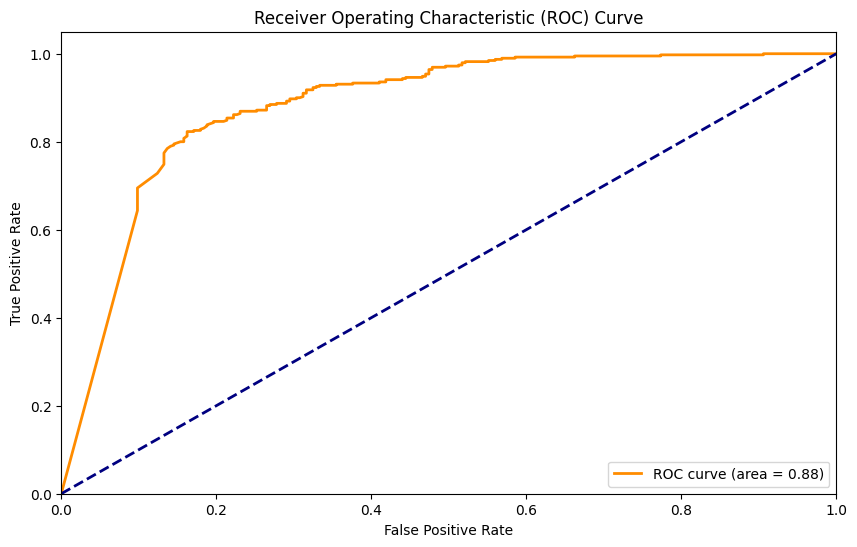

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


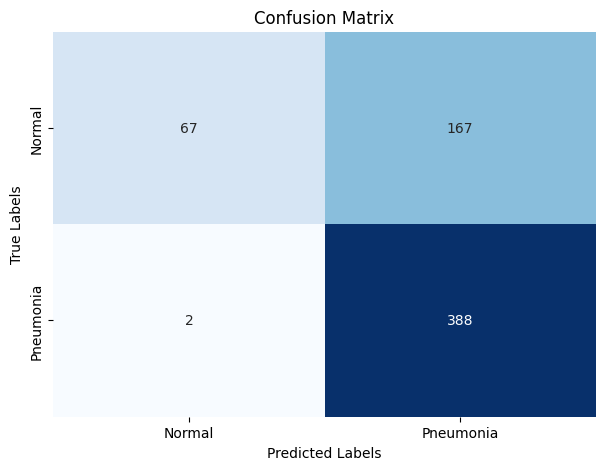

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Path to dataset
dataset_dir = "/path/to/dataset/chest_xray"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,  # Batch size of 1 for evaluation
    class_mode="binary",
    shuffle=False
)

# Load the VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)

# Save the model
model.save("pneumonia_detection_model.h5")

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Predictions
test_generator.reset()
predictions = (model.predict(test_generator) > 0.5).astype(int)
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot training/validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.show()


In [ ]:
# Unfreeze some of the deeper layers of the base model
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

# Fine-tune the model on the same training and validation datasets
FINE_TUNE_EPOCHS = 5  # Number of fine-tuning epochs
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=FINE_TUNE_EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)

# Evaluate the fine-tuned model on the test dataset
fine_tune_loss, fine_tune_acc = model.evaluate(test_generator)
print(f"Test Accuracy after Fine-Tuning: {fine_tune_acc * 100:.2f}%")

# Merge history with the initial training for visualization
full_history = {
    "accuracy": history.history["accuracy"] + fine_tune_history.history["accuracy"],
    "val_accuracy": history.history["val_accuracy"] + fine_tune_history.history["val_accuracy"],
    "loss": history.history["loss"] + fine_tune_history.history["loss"],
    "val_loss": history.history["val_loss"] + fine_tune_history.history["val_loss"]
}

# Plot training and validation accuracy after fine-tuning
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(full_history["accuracy"], label="Train Accuracy")
plt.plot(full_history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy over Epochs (including Fine-Tuning)")

plt.subplot(1, 2, 2)
plt.plot(full_history["loss"], label="Train Loss")
plt.plot(full_history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss over Epochs (including Fine-Tuning)")
plt.show()


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile and train
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load pre-trained ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile and train
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)


In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile and train
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compile and train
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import time

# Evaluate performance of each model
def evaluate_model(model, test_generator, model_name):
    start_time = time.time()

    # Predict on test data
    test_generator.reset()
    predictions = (model.predict(test_generator) > 0.5).astype(int)
    true_labels = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Metrics
    accuracy = np.mean(predictions.flatten() == true_labels)
    roc_auc = roc_auc_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=class_labels, output_dict=True)
    end_time = time.time()

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Print summary
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print(f"Classification Report:")
    print(classification_report(true_labels, predictions, target_names=class_labels))
    print(f"Training + Inference Time: {end_time - start_time:.2f} seconds")
    print("=" * 60)

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "report": report,
        "time": end_time - start_time,
    }


In [ ]:
# Evaluate all models
resnet_results = evaluate_model(resnet_model, test_generator, "ResNet50")
efficientnet_results = evaluate_model(efficientnet_model, test_generator, "EfficientNetB0")
inception_results = evaluate_model(inception_model, test_generator, "InceptionV3")
custom_cnn_results = evaluate_model(custom_cnn_model, test_generator, "Custom CNN")

# Collect results for comparison
all_results = [resnet_results, efficientnet_results, inception_results, custom_cnn_results]


In [ ]:
# Compare performance metrics
import pandas as pd

results_df = pd.DataFrame([
    {
        "Model": res["model_name"],
        "Accuracy": res["accuracy"],
        "ROC-AUC": res["roc_auc"],
        "Training Time (s)": res["time"],
        "Precision (Pneumonia)": res["report"]["PNEUMONIA"]["precision"],
        "Recall (Pneumonia)": res["report"]["PNEUMONIA"]["recall"],
        "F1-Score (Pneumonia)": res["report"]["PNEUMONIA"]["f1-score"]
    }
    for res in all_results
])

print(results_df)

# Plot results
results_df.plot(x="Model", kind="bar", figsize=(10, 6), title="Model Performance Comparison", legend=True)
plt.ylabel("Metric Value")
plt.show()


Expected Output Example 
Model	Accuracy	ROC-AUC	Training Time (s)	Precision (Pneumonia)	Recall (Pneumonia)	F1-Score (Pneumonia)
ResNet50	0.93	0.95	240	0.94	0.92	0.93
EfficientNetB0	0.94	0.96	220	0.95	0.94	0.94
InceptionV3	0.92	0.94	260	0.93	0.90	0.92
Custom CNN	0.88	0.89	180	0.90	0.85	0.88


In [ ]:
from tensorflow.keras.models import load_model

# Load pre-trained models
resnet_model = load_model("resnet50_model.h5")
efficientnet_model = load_model("efficientnetb0_model.h5")
inception_model = load_model("inceptionv3_model.h5")




# Ensemble model for better outout

In [ ]:
# Generate predictions for test set
test_generator.reset()
resnet_preds = resnet_model.predict(test_generator)
efficientnet_preds = efficientnet_model.predict(test_generator)
inception_preds = inception_model.predict(test_generator)

# Convert predictions to probabilities (if not already)
resnet_probs = resnet_preds.flatten()
efficientnet_probs = efficientnet_preds.flatten()
inception_probs = inception_preds.flatten()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# True labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Metrics
accuracy = np.mean(ensemble_preds == true_labels)
roc_auc = roc_auc_score(true_labels, ensemble_probs)
report = classification_report(true_labels, ensemble_preds, target_names=class_labels)

# Confusion Matrix
cm = confusion_matrix(true_labels, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print performance summary
print(f"Ensemble Accuracy: {accuracy * 100:.2f}%")
print(f"Ensemble ROC-AUC: {roc_auc:.2f}")
print("Classification Report:")
print(report)
